In [62]:
import pathlib
import numpy as np
from keras.models import Sequential, model_from_json
from keras.layers import Bidirectional, LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import pystan

%matplotlib notebook


# Set functions to clean and scale data

There is a lot of collinearity in the data, which makes sense given that many of the variables are lag/rolling-averages. The ranges on the different parameters also varies wildly, which suggests a need for scaling. These helper functions accomplish a few things:
<ol>
    <li>Converts the data to train/test splits</li>
    <li>Removes non-numeric parameters</li>
    <li>Scales each parameter</li>
    <li>Split data by zip if a separate model by zip code is necessary</li>
    <li>Reproducible models by function</li>
</ol>

In [49]:
current_dir = pathlib.Path.cwd()
repopath = pathlib.Path(current_dir).resolve().parents[1]
datapath = repopath / pathlib.Path('data/processed')
# fulldatpath = datapath / pathlib.Path('wnv.trap.date.rev3b.csv')
fulldatpath = pathlib.Path('c:/github/capstone_project/data/processed')
# outpath = datapath.resolve().parents[0] / pathlib.Path('output')
outpath = pathlib.Path('c:/github/capstone_project/data/output')
filepath = fulldatpath / pathlib.Path("wnv.trap.date.rev3b.csv")
scaler = StandardScaler()
le = LabelEncoder()
dat = pd.read_csv(filepath, parse_dates = ['t_date'])

dat.trap_trap_type = le.fit_transform(dat.trap_trap_type)
# dat.trap_trap_name = le.fit_transform(dat.trap_trap_name)

def get_relevant_columns(df, colname):
    cols = list()
    for col in df.columns.tolist():
        if (not 'mos_' in col) & (col != colname) & (df[col].dtypes != 'object') & (df[col].dtypes != '<M8[ns]'):
            cols.append(col)
    cols.append(colname)
    return cols

def make_x(df, colname):
    cols = get_relevant_columns(df, colname)
    exclude_cols = ['part_train', 'part_validate', 'part_test', colname]
    scaler.fit(dat[cols].drop(exclude_cols, axis = 1))
    train_x = scaler.transform(df.loc[df.part_train == True, cols].drop(exclude_cols, axis = 1))
    train_y = df.loc[df.part_train == True, colname]
    valid_x = scaler.transform(df.loc[df.part_validate == True, cols].drop(exclude_cols, axis = 1))
    valid_y = df.loc[df.part_validate == True, colname]
    test_x = scaler.transform(df.loc[df.part_test == True, cols].drop(exclude_cols, axis = 1))
    test_y = df.loc[df.part_test == True, colname]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

def split_zip(df, colname, zipcode):
    cols = get_relevant_columns(df, colname)
    out = df.loc[df.loc_zipcode == zipcode, cols].groupby('t_date').mean()
    scaler = MinMaxScaler()
    scaler.fit(df[cols].drop('t_date', axis = 1))
    out = scaler.transform(out)
    return out, df[colname]

def make_model():
    model = Sequential()
    model.add(Dense(50, input_dim = 108, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def ridge_model(X, y, test_X, test_Y, colname):
    ridge = Ridge()
    ridge_params = {'alpha': [.0001, .001, .01, .1, .5, 1],
                'normalize': [True, False],
                'tol': [.0001, .001, .01], 'solver': ['auto', 'svd', ]}
    ridge = GridSearchCV(estimator = ridge, param_grid = ridge_params, n_jobs = 1)
    ridge.fit(X, y)
    preds_out = pd.DataFrame(test_Y,)
    preds_out['predicted_'+colname+'_mosquitos'] = ridge.predict(test_X)
    filename = 'optimized_ridge.sav'
    pickle.dump(ridge, open(filename, 'wb'))
#     preds_out.to_csv(outpath / pathlib.Path('regr_ridge_' + colname + '_predictions.csv'), index = False)
    return ridge

def rf_model(X, y, test_X, test_Y, colname):
    rf = RandomForestRegressor()
    rf_params = {'n_estimators': [100, 500, 1000, ],
                'max_depth': [2, 3, 4],
                'min_samples_leaf': [1, 2, 3], 
             'max_features': ['auto', ]}
    rf = GridSearchCV(estimator = rf, param_grid = rf_params, )
    rf.fit(X, y)
    preds_out = pd.DataFrame(test_Y,)
    preds_out['predicted_'+colname+'_mosquitos'] = rf.predict(test_X)
    filename = 'optimized_randomforest.sav'
    pickle.dump(rf, open(filename, 'wb'))
#     preds_out.to_csv(outpath / pathlib.Path('regr_randomforest_' + colname + '_predictions.csv'), index = False)
    return rf
    
def basic_nnet(X, y, test_X, test_Y, colname):
    earlystopper = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, 
                       mode='auto', baseline=None, restore_best_weights=True)
    model = Sequential()
    model.add(Dense(50, input_dim = X.shape[1], kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dense(10,activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mse')
    model.fit(X, y, epochs = 100, callbacks = [earlystopper])
    preds_out = pd.DataFrame(test_Y,)
    preds_out['predicted_'+colname+'_mosquitos'] = model.predict(test_X)
#     preds_out.to_csv(outpath / pathlib.Path('basic_neural_net_' + colname + '_predictions.csv'), index = False)
    return model
    
    
def LSTM_model(X, y, test_X, test_Y, colname):
    earlystopper = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, 
                       mode='auto', baseline=None, restore_best_weights=True)
    X = pd.DataFrame(X)
    X = pd.concat([X, X.shift(1), X.shift(2), X.shift(3)], axis = 1).fillna(0).values
    X = X.reshape((X.shape[0], 1, X.shape[1]))
    model = Sequential()
    model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss = 'mae', optimizer = 'adamax')
    history = model.fit(X, y, epochs = 200, batch_size = 10, shuffle = False, verbose = 2, callbacks = [earlystopper])
    return model

In [50]:
train_x, train_y, valid_x, valid_y, test_x, test_y = make_x(dat, 'mos_tot_num_mosquitos')
rp = ridge_model(train_x, train_y, valid_x, valid_y, 'mos_tot_num_mosquitos')

# Troubleshoot why Ridge is so good at predicting

In [60]:
# testridge = Ridge(rp.best_params_)
# testridge.fit(train_x, train_y)
rp.best_params_
testridge = Ridge(alpha = 1, normalize = True, solver = 'auto', tol = 0.0001)
testridge.fit(train_x, train_y)
testridge.coef_

pd.DataFrame({'ridge_coefficients': testridge.coef_, 
              'params': dat[get_relevant_columns(dat, 'mos_tot_num_mosquitos')].drop(['part_train', 'part_validate', 'part_test', 'mos_tot_num_mosquitos'], axis = 1).columns,
             }).sort_values('ridge_coefficients', ascending = False)
pd.DataFrame({'actuals': valid_y,
             'preds': testridge.predict(valid_x)})

,actuals,preds
8222,84,21.544402
8223,9,13.671897
8224,82,21.001988
8225,90,11.836278
8226,46,11.186486
8227,15,11.584674
8228,2,14.321546
8229,15,22.710196
8230,32,10.456963
8231,54,20.141555


In [74]:
# x_ = pd.DataFrame(valid_x)
# x_ = pd.concat([x_, x_.shift(1), x_.shift(2), x_.shift(3)], axis = 1).fillna(0).values
# x_ = x_.reshape(x_.shape[0], 1, x_.shape[1])
# outpreds = lstm_mod.predict(x_)
# pd.DataFrame({'actuals': valid_y, 'preds': lstm_mod.predict(x_).reshape(-1,)})
# outpreds.reshape(-1,).shape
# testshape = vali
# valid_x.shape
mos_cols = ['mos_erraticus_num_mosquitos','mos_pipiens_num_mosquitos','mos_pipiens_restuans_num_mosquitos',
            'mos_restuans_num_mosquitos','mos_salinarius_num_mosquitos', 'mos_tarsalis_num_mosquitos',
            'mos_territans_num_mosquitos',  'mos_unspecified_num_mosquitos','mos_tot_num_mosquitos']
for mos in mos_cols:
    train_x, train_y, valid_x, valid_y, test_x, test_y = make_x(dat, mos)
    outdf = dat.loc[dat.part_validate == True, ['t_date', 'loc_lat', 'loc_lng', 'trap_trap_name', mos]]
    ridge = ridge_model(train_x, train_y, valid_x, valid_y, mos)
    outdf['ridgepreds'] = ridge.predict(valid_x)
    nnet = basic_nnet(train_x, train_y, valid_x, valid_y, mos)
    outdf['neuralnetpreds'] = nnet.predict(valid_x)
    rf = rf_model(train_x, train_y, valid_x, valid_y, mos)
    outdf['rf_preds'] = rf.predict(valid_x)
    test_X = pd.DataFrame(valid_x)
    test_X = pd.concat([test_X, test_X.shift(1), test_X.shift(2), test_X.shift(3)], axis = 1).fillna(0).values
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    lstm_ = LSTM_model(train_x, train_y, test_X, valid_y, mos)
    outdf['lstm_preds'] = lstm_.predict(test_X)
    savepath = outpath / pathlib.Path('assembled_predictions_{}_mosquitos.csv'.format(mos))
    outdf.to_csv(savepath, index = False)

Epoch 1/100
8222/8222 [==============================] - 4s 500us/step - loss: 0.0064
Epoch 2/100
8222/8222 [==============================] - 0s 35us/step - loss: 0.0046
Epoch 3/100
8222/8222 [==============================] - 0s 40us/step - loss: 0.0016
Epoch 4/100
8222/8222 [==============================] - 0s 40us/step - loss: 0.0028
Epoch 5/100
8222/8222 [==============================] - 0s 37us/step - loss: 0.0077
Epoch 6/100
8222/8222 [==============================] - 0s 41us/step - loss: 0.0058
Epoch 1/200
 - 12s - loss: 0.0013
Epoch 2/200
 - 6s - loss: 0.0011
Epoch 3/200
 - 6s - loss: 0.0010
Epoch 4/200
 - 6s - loss: 0.0010
Epoch 5/200
 - 6s - loss: 0.0011
Epoch 6/200
 - 6s - loss: 0.0010
Epoch 7/200
 - 6s - loss: 0.0012
Epoch 8/200
 - 6s - loss: 0.0010
Epoch 9/200
 - 6s - loss: 0.0011
Epoch 10/200
 - 6s - loss: 9.9704e-04
Epoch 11/200
 - 6s - loss: 0.0010
Epoch 12/200
 - 6s - loss: 0.0010
Epoch 13/200
 - 7s - loss: 0.0011
Epoch 1/100
8222/8222 [============================

KeyboardInterrupt: 

In [14]:
from scipy.optimize import fmin, minimize
valid_preds = outpath / pathlib.Path('assembled_predictions_mos_pipiens_restuans_num_mosquitos_mosquitos.csv')
train_df = pd.read_csv(valid_preds)
train_df
y = train_df[train_df.columns[4]].values
y = y.reshape(-1, 1)
train_df['constant'] = 1
train_df.head()
columns = ['constant', 'ridgepreds', 'neuralnetpreds', 'rf_preds', 'lstm_preds', ]
x = train_df[columns].values
print(x.shape[1])
w = np.zeros([x.shape[1], 1])
def pred(x, w):
    return np.dot(x, w)
  
y_pred = pred(x, w)

def loss(_w):
    p = pred(x, _w)
    e = y - p
    se = np.power(e, 2)
    rse = np.sqrt(np.sum(se))
    rmse = rse / y.shape[0]
    return rmse

# nms = minimize(loss, w, method='nelder-mead')
# pd.DataFrame({'y': y[:,0], 'y_pred': y_pred[:,0], 'y_min': pred(x, nms.x)})

5


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [3]:
# dat.trap_trap_name.unique()
# relcols = get_relevant_columns(trap1, 'mos_tot_num_mosquitos')
# relcols.append('t_date')
# trap1[relcols].groupby(['t_date']).mean()

def get_trap_data(df, trapname, colname):
    trap = df.loc[df.trap_trap_name == trapname,]
    relcols = get_relevant_columns(trap, colname)
    relcols.append('t_date')
    trap = trap[relcols].groupby('t_date').mean()
    return trap


def setup_lstm(df):
    lagdf = df.shift(-1)
    lagdf.columns = [(x + ' (t-1)') for x in lagdf.columns]
    lagdf2 = df.shift(-2)
    lagdf2.columns = [(x + ' (t-2)' ) for x in lagdf2.columns]
    dat = pd.concat([df, lagdf], axis = 1)
    dat = pd.concat([dat, lagdf2], axis = 1)
    return dat
# trap1 = dat.loc[dat.trap_trap_name == 'T002',]
trap1 = get_trap_data(dat, 'T002', 'mos_tot_num_mosquitos')
testtrap = setup_lstm(trap1)

                     
def LSTM_preds_by_trap(df, trapname, colname):
    dat = get_trap_data(df, trapname, colname).fillna(0)#.drop(colname, axis = 1)
    dat = setup_lstm(dat)
    train_x = dat.loc[dat.part_train == True,].drop(colname, axis = 1) 
    train_y = dat.loc[dat.part_train == True, colname] 
    valid_x = dat.loc[dat.part_validate == True,].drop(colname, axis = 1) 
    valid_y = dat.loc[dat.part_validate == True, colname] 
    test_x = dat.loc[dat.part_test == True,].drop(colname, axis = 1) 
    test_y = dat.loc[dat.part_test == True, colname] 
    scaler = MinMaxScaler()
    try:
        x_scaler = scaler.fit(dat.fillna(0).drop(colname, axis = 1))
        X = x_scaler.transform(train_x)
        X = X.reshape((X.shape[0], 1, X.shape[1]))
        y = train_y.values
        model = Sequential()
        model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss = 'mae', optimizer = 'adamax')
        history = model.fit(X, y, epochs = 200, batch_size = 10, shuffle = False, verbose = 2, callbacks = [earlystopper])
        validset = x_scaler.transform(valid_x)
        validset = validset.reshape((validset.shape[0], 1, validset.shape[1]))
        lstm_preds = model.predict(validset)
        preds_out = pd.DataFrame(valid_y,)
        preds_out['lstm_preds'] = lstm_preds
        preds_out.to_csv(outpath / pathlib.Path('lstm_neural_net_' + colname + trapname + '_predictions.csv'), index = False)
    except:
        lstm_preds = [0] * len(valid_y)
        preds_out = pd.DataFrame(valid_y,)
        preds_out['lstm_preds'] = lstm_preds
        preds_out.to_csv(outpath / pathlib.Path('lstm_neural_net_' + colname + trapname + '_predictions.csv'), index = False)
    return model
#         names += [()]
# get_trap_data(dat, 'T002', 'mos_tot_num_mosquitos')
# trap1 = trap1[['t_date',get_relevant_columns(trap1, 'mos_tot_num_mosquitos')]]#.groupby()
# trap1.head(10)
# train_x, train_y, valid_x, valid_y, test_x, test_y = make_x(trap1, 'mos_tot_num_mosquitos')
# LSTM_preds(dat, 'T002', 'mos_tot_num_mosquitos')

In [63]:

train_x_df = pd.DataFrame(train_x)
train_x_df = pd.concat([train_x_df, train_x_df.shift(1), train_x_df.shift(2), train_x_df.shift(3)], axis = 1).dropna().values
train_x_df = train_x_df.reshape((train_x_df.shape[0], 1, train_x_df.shape[1]))


TypeError: LSTM() got an unexpected keyword argument 'input_shape'

In [ ]:
mos_cols = ['mos_erraticus_num_mosquitos','mos_pipiens_num_mosquitos','mos_pipiens_restuans_num_mosquitos',
            'mos_restuans_num_mosquitos','mos_salinarius_num_mosquitos', 'mos_tarsalis_num_mosquitos',
            'mos_territans_num_mosquitos',  'mos_unspecified_num_mosquitos','mos_tot_num_mosquitos']
for trap in dat.trap_trap_name.unique():
    for mos in mos_cols:
        print("predicting {} for trap {}".format(mos, trap))
        try:
            LSTM_preds(dat, trap, mos)
        except:
            continue

predicting mos_erraticus_num_mosquitos for trap T002
Epoch 1/200
 - 5s - loss: 0.0012
Epoch 2/200
 - 0s - loss: 7.8218e-04
Epoch 3/200
 - 0s - loss: 7.1463e-04
Epoch 4/200
 - 0s - loss: 5.0995e-04
Epoch 5/200
 - 0s - loss: 2.8524e-04
Epoch 6/200
 - 0s - loss: 2.3548e-04
Epoch 7/200
 - 0s - loss: 2.6177e-04
Epoch 8/200
 - 0s - loss: 3.0186e-04
Epoch 9/200
 - 0s - loss: 1.5682e-04
Epoch 10/200
 - 0s - loss: 3.6100e-04
Epoch 11/200
 - 0s - loss: 4.0596e-04
Epoch 12/200
 - 0s - loss: 4.8418e-04
Epoch 13/200
 - 0s - loss: 3.1546e-04
Epoch 14/200
 - 0s - loss: 4.1458e-04
Epoch 15/200
 - 0s - loss: 5.6956e-04
Epoch 16/200
 - 0s - loss: 4.9433e-04
Epoch 17/200
 - 0s - loss: 5.0739e-04
predicting mos_pipiens_num_mosquitos for trap T002
Epoch 1/200
 - 5s - loss: 6.2471
Epoch 2/200
 - 0s - loss: 6.2462
Epoch 3/200
 - 0s - loss: 6.2463
Epoch 4/200
 - 0s - loss: 6.2458
Epoch 5/200
 - 0s - loss: 6.2461
Epoch 6/200
 - 0s - loss: 6.2466
Epoch 7/200
 - 0s - loss: 6.2459
Epoch 8/200
 - 0s - loss: 6.2452

 - 0s - loss: 0.0967
Epoch 12/200
 - 0s - loss: 0.0970
Epoch 13/200
 - 0s - loss: 0.0970
Epoch 14/200
 - 0s - loss: 0.0969
Epoch 15/200
 - 0s - loss: 0.0969
Epoch 16/200
 - 0s - loss: 0.0968
Epoch 17/200
 - 0s - loss: 0.0967
Epoch 18/200
 - 0s - loss: 0.0967
Epoch 19/200
 - 0s - loss: 0.0967
Epoch 20/200
 - 0s - loss: 0.0969
Epoch 21/200
 - 0s - loss: 0.0970
Epoch 22/200
 - 0s - loss: 0.0969
Epoch 23/200
 - 0s - loss: 0.0969
Epoch 24/200
 - 0s - loss: 0.0967
Epoch 25/200
 - 0s - loss: 0.0968
Epoch 26/200
 - 0s - loss: 0.0970
Epoch 27/200
 - 0s - loss: 0.0970
predicting mos_tarsalis_num_mosquitos for trap T002
Epoch 1/200
 - 6s - loss: 0.0030
Epoch 2/200
 - 0s - loss: 0.0010
Epoch 3/200
 - 0s - loss: 7.1250e-04
Epoch 4/200
 - 0s - loss: 5.5576e-04
Epoch 5/200
 - 0s - loss: 4.2947e-04
Epoch 6/200
 - 0s - loss: 4.4821e-04
Epoch 7/200
 - 0s - loss: 4.5990e-04
Epoch 8/200
 - 0s - loss: 3.9313e-04
Epoch 9/200
 - 0s - loss: 2.5024e-04
Epoch 10/200
 - 0s - loss: 1.6074e-04
Epoch 11/200
 - 0s -

Epoch 22/200
 - 0s - loss: 2.2980
Epoch 23/200
 - 0s - loss: 2.2974
Epoch 24/200
 - 0s - loss: 2.2976
Epoch 25/200
 - 0s - loss: 2.2973
Epoch 26/200
 - 0s - loss: 2.2971
Epoch 27/200
 - 0s - loss: 2.2980
Epoch 28/200
 - 0s - loss: 2.2976
Epoch 29/200
 - 0s - loss: 2.2977
predicting mos_pipiens_restuans_num_mosquitos for trap T046
Epoch 1/200
 - 9s - loss: 5.4053
Epoch 2/200
 - 0s - loss: 5.3461
Epoch 3/200
 - 0s - loss: 5.2653
Epoch 4/200
 - 0s - loss: 5.1176
Epoch 5/200
 - 0s - loss: 4.9278
Epoch 6/200
 - 0s - loss: 4.6778
Epoch 7/200
 - 0s - loss: 4.5914
Epoch 8/200
 - 0s - loss: 4.5629
Epoch 9/200
 - 0s - loss: 4.5037
Epoch 10/200
 - 0s - loss: 4.4480
Epoch 11/200
 - 0s - loss: 4.4125
Epoch 12/200
 - 0s - loss: 4.4797
Epoch 13/200
 - 0s - loss: 4.4528
Epoch 14/200
 - 0s - loss: 4.4840
Epoch 15/200
 - 0s - loss: 4.4641
Epoch 16/200
 - 0s - loss: 4.4108
Epoch 17/200
 - 0s - loss: 4.4105
Epoch 18/200
 - 0s - loss: 4.4318
Epoch 19/200
 - 0s - loss: 4.3960
Epoch 20/200
 - 0s - loss: 4.44

Epoch 57/200
 - 0s - loss: 7.2434
predicting mos_erraticus_num_mosquitos for trap T048
Epoch 1/200
 - 12s - loss: 0.0026
Epoch 2/200
 - 0s - loss: 0.0012
Epoch 3/200
 - 0s - loss: 0.0010
Epoch 4/200
 - 0s - loss: 5.5439e-04
Epoch 5/200
 - 0s - loss: 3.1724e-04
Epoch 6/200
 - 0s - loss: 2.6467e-04
Epoch 7/200
 - 0s - loss: 3.3369e-04
Epoch 8/200
 - 0s - loss: 2.2195e-04
Epoch 9/200
 - 0s - loss: 2.7387e-04
Epoch 10/200
 - 0s - loss: 5.0499e-04
Epoch 11/200
 - 0s - loss: 3.0917e-04
Epoch 12/200
 - 0s - loss: 2.3433e-04
Epoch 13/200
 - 0s - loss: 1.9530e-04
Epoch 14/200
 - 0s - loss: 2.0905e-04
Epoch 15/200
 - 0s - loss: 4.0451e-04
Epoch 16/200
 - 0s - loss: 3.5415e-04
Epoch 17/200
 - 0s - loss: 2.0932e-04
Epoch 18/200
 - 0s - loss: 2.5829e-04
Epoch 19/200
 - 0s - loss: 3.5321e-04
Epoch 20/200
 - 0s - loss: 2.9732e-04
Epoch 21/200
 - 0s - loss: 2.5494e-04
predicting mos_pipiens_num_mosquitos for trap T048
Epoch 1/200
 - 13s - loss: 2.2703
Epoch 2/200
 - 0s - loss: 2.2694
Epoch 3/200
 - 0s

Epoch 21/200
 - 0s - loss: 0.0836
Epoch 22/200
 - 0s - loss: 0.0838
Epoch 23/200
 - 0s - loss: 0.0837
Epoch 24/200
 - 0s - loss: 0.0837
predicting mos_tarsalis_num_mosquitos for trap T048
Epoch 1/200
 - 15s - loss: 0.0017
Epoch 2/200
 - 0s - loss: 7.2822e-04
Epoch 3/200
 - 0s - loss: 6.4900e-04
Epoch 4/200
 - 0s - loss: 5.9047e-04
Epoch 5/200
 - 0s - loss: 7.0018e-04
Epoch 6/200
 - 0s - loss: 5.9552e-04
Epoch 7/200
 - 0s - loss: 5.0391e-04
Epoch 8/200
 - 0s - loss: 5.2261e-04
Epoch 9/200
 - 0s - loss: 2.9173e-04
Epoch 10/200
 - 0s - loss: 2.6925e-04
Epoch 11/200
 - 0s - loss: 2.1282e-04
Epoch 12/200
 - 0s - loss: 2.3261e-04
Epoch 13/200
 - 0s - loss: 1.8734e-04
Epoch 14/200
 - 0s - loss: 2.7622e-04
Epoch 15/200
 - 0s - loss: 2.0337e-04
Epoch 16/200
 - 0s - loss: 1.8356e-04
Epoch 17/200
 - 0s - loss: 3.0543e-04
Epoch 18/200
 - 0s - loss: 2.7574e-04
Epoch 19/200
 - 0s - loss: 4.2888e-04
Epoch 20/200
 - 0s - loss: 5.2128e-04
Epoch 21/200
 - 0s - loss: 3.3345e-04
Epoch 22/200
 - 0s - loss:

Epoch 39/200
 - 0s - loss: 3.4266
Epoch 40/200
 - 0s - loss: 3.3868
Epoch 41/200
 - 0s - loss: 3.3634
Epoch 42/200
 - 0s - loss: 3.3541
Epoch 43/200
 - 0s - loss: 3.3277
Epoch 44/200
 - 0s - loss: 3.2979
Epoch 45/200
 - 0s - loss: 3.3336
Epoch 46/200
 - 0s - loss: 3.3057
Epoch 47/200
 - 0s - loss: 3.2138
Epoch 48/200
 - 0s - loss: 3.2255
Epoch 49/200
 - 0s - loss: 3.2845
Epoch 50/200
 - 0s - loss: 3.1690
Epoch 51/200
 - 0s - loss: 3.1383
Epoch 52/200
 - 0s - loss: 3.0883
Epoch 53/200
 - 0s - loss: 3.1232
Epoch 54/200
 - 0s - loss: 3.2051
Epoch 55/200
 - 0s - loss: 3.1638
Epoch 56/200
 - 0s - loss: 3.1877
Epoch 57/200
 - 0s - loss: 3.0128
Epoch 58/200
 - 0s - loss: 3.0388
Epoch 59/200
 - 0s - loss: 2.9765
Epoch 60/200
 - 0s - loss: 3.0408
Epoch 61/200
 - 0s - loss: 3.0241
Epoch 62/200
 - 0s - loss: 3.0346
Epoch 63/200
 - 0s - loss: 3.0948
Epoch 64/200
 - 0s - loss: 2.9928
Epoch 65/200
 - 0s - loss: 3.1434
Epoch 66/200
 - 0s - loss: 3.0463
Epoch 67/200
 - 0s - loss: 3.1111
predicting mos

predicting mos_unspecified_num_mosquitos for trap T087
predicting mos_tot_num_mosquitos for trap T087
predicting mos_erraticus_num_mosquitos for trap T091
predicting mos_pipiens_num_mosquitos for trap T091
predicting mos_pipiens_restuans_num_mosquitos for trap T091
predicting mos_restuans_num_mosquitos for trap T091
predicting mos_salinarius_num_mosquitos for trap T091
predicting mos_tarsalis_num_mosquitos for trap T091
predicting mos_territans_num_mosquitos for trap T091
predicting mos_unspecified_num_mosquitos for trap T091
predicting mos_tot_num_mosquitos for trap T091
predicting mos_erraticus_num_mosquitos for trap T094
Epoch 1/200
 - 25s - loss: 0.0031
Epoch 2/200
 - 0s - loss: 0.0013
Epoch 3/200
 - 0s - loss: 4.0393e-04
Epoch 4/200
 - 0s - loss: 3.4468e-04
Epoch 5/200
 - 0s - loss: 2.6776e-04
Epoch 6/200
 - 0s - loss: 2.4953e-04
Epoch 7/200
 - 0s - loss: 1.8185e-04
Epoch 8/200
 - 0s - loss: 1.7131e-04
Epoch 9/200
 - 0s - loss: 2.7439e-04
Epoch 10/200
 - 0s - loss: 3.3980e-04
Epoc

 - 0s - loss: 1.9866e-04
Epoch 22/200
 - 0s - loss: 2.1986e-04
Epoch 23/200
 - 0s - loss: 2.1276e-04
Epoch 24/200
 - 0s - loss: 1.7116e-04
Epoch 25/200
 - 0s - loss: 2.2263e-04
Epoch 26/200
 - 0s - loss: 3.2457e-04
Epoch 27/200
 - 0s - loss: 1.6281e-04
Epoch 28/200
 - 0s - loss: 2.0903e-04
Epoch 29/200
 - 0s - loss: 2.1561e-04
Epoch 30/200
 - 0s - loss: 2.7120e-04
Epoch 31/200
 - 0s - loss: 5.1168e-04
Epoch 32/200
 - 0s - loss: 3.8569e-04
Epoch 33/200
 - 0s - loss: 4.1286e-04
Epoch 34/200
 - 0s - loss: 3.1087e-04
Epoch 35/200
 - 0s - loss: 3.0259e-04
predicting mos_territans_num_mosquitos for trap T094
Epoch 1/200
 - 25s - loss: 0.0776
Epoch 2/200
 - 0s - loss: 0.0770
Epoch 3/200
 - 0s - loss: 0.0770
Epoch 4/200
 - 0s - loss: 0.0767
Epoch 5/200
 - 0s - loss: 0.0765
Epoch 6/200
 - 0s - loss: 0.0766
Epoch 7/200
 - 0s - loss: 0.0766
Epoch 8/200
 - 0s - loss: 0.0765
Epoch 9/200
 - 0s - loss: 0.0765
Epoch 10/200
 - 0s - loss: 0.0769
Epoch 11/200
 - 0s - loss: 0.0765
Epoch 12/200
 - 0s - los

 - 0s - loss: 6.5982
Epoch 28/200
 - 0s - loss: 6.4702
Epoch 29/200
 - 0s - loss: 6.5703
Epoch 30/200
 - 0s - loss: 6.5098
Epoch 31/200
 - 0s - loss: 6.4753
Epoch 32/200
 - 0s - loss: 6.4662
Epoch 33/200
 - 0s - loss: 6.4762
Epoch 34/200
 - 0s - loss: 6.4625
Epoch 35/200
 - 0s - loss: 6.4023
Epoch 36/200
 - 0s - loss: 6.4259
Epoch 37/200
 - 0s - loss: 6.4692
Epoch 38/200
 - 0s - loss: 6.3654
Epoch 39/200
 - 0s - loss: 6.4737
Epoch 40/200
 - 0s - loss: 6.4557
Epoch 41/200
 - 0s - loss: 6.3604
Epoch 42/200
 - 0s - loss: 6.3435
Epoch 43/200
 - 0s - loss: 6.3712
Epoch 44/200
 - 0s - loss: 6.4427
Epoch 45/200
 - 0s - loss: 6.4157
Epoch 46/200
 - 0s - loss: 6.4697
Epoch 47/200
 - 0s - loss: 6.3734
Epoch 48/200
 - 0s - loss: 6.3960
Epoch 49/200
 - 0s - loss: 6.2713
Epoch 50/200
 - 0s - loss: 6.2839
Epoch 51/200
 - 0s - loss: 6.4498
Epoch 52/200
 - 0s - loss: 6.2815
Epoch 53/200
 - 0s - loss: 6.3948
Epoch 54/200
 - 0s - loss: 6.3504
Epoch 55/200
 - 0s - loss: 6.3851
Epoch 56/200
 - 0s - loss: 

 - 0s - loss: 6.6316
Epoch 44/200
 - 0s - loss: 6.6285
Epoch 45/200
 - 0s - loss: 6.6218
Epoch 46/200
 - 0s - loss: 6.6065
Epoch 47/200
 - 0s - loss: 6.5949
Epoch 48/200
 - 0s - loss: 6.5808
Epoch 49/200
 - 0s - loss: 6.5783
Epoch 50/200
 - 0s - loss: 6.5573
Epoch 51/200
 - 0s - loss: 6.5467
Epoch 52/200
 - 0s - loss: 6.4968
Epoch 53/200
 - 0s - loss: 6.5299
Epoch 54/200
 - 0s - loss: 6.4910
Epoch 55/200
 - 0s - loss: 6.4793
Epoch 56/200
 - 0s - loss: 6.4569
Epoch 57/200
 - 0s - loss: 6.4598
Epoch 58/200
 - 1s - loss: 6.3985
Epoch 59/200
 - 0s - loss: 6.4985
Epoch 60/200
 - 1s - loss: 6.4098
Epoch 61/200
 - 0s - loss: 6.3721
Epoch 62/200
 - 0s - loss: 6.3346
Epoch 63/200
 - 0s - loss: 6.3490
Epoch 64/200
 - 0s - loss: 6.3073
Epoch 65/200
 - 0s - loss: 6.2949
Epoch 66/200
 - 0s - loss: 6.3019
Epoch 67/200
 - 0s - loss: 6.1917
Epoch 68/200
 - 1s - loss: 6.2466
Epoch 69/200
 - 0s - loss: 6.2059
Epoch 70/200
 - 0s - loss: 6.1783
Epoch 71/200
 - 0s - loss: 6.2081
Epoch 72/200
 - 0s - loss: 

Epoch 3/200
 - 1s - loss: 6.4609e-04
Epoch 4/200
 - 1s - loss: 9.0764e-04
Epoch 5/200
 - 1s - loss: 7.1652e-04
Epoch 6/200
 - 1s - loss: 3.5561e-04
Epoch 7/200
 - 1s - loss: 5.3974e-04
Epoch 8/200
 - 1s - loss: 3.8306e-04
Epoch 9/200
 - 1s - loss: 2.6480e-04
Epoch 10/200
 - 1s - loss: 3.1297e-04
Epoch 11/200
 - 1s - loss: 3.8393e-04
Epoch 12/200
 - 1s - loss: 2.3066e-04
Epoch 13/200
 - 1s - loss: 1.7735e-04
Epoch 14/200
 - 1s - loss: 2.0651e-04
Epoch 15/200
 - 1s - loss: 2.0511e-04
Epoch 16/200
 - 1s - loss: 3.2740e-04
Epoch 17/200
 - 1s - loss: 7.8376e-04
Epoch 18/200
 - 1s - loss: 3.7966e-04
Epoch 19/200
 - 1s - loss: 2.2121e-04
Epoch 20/200
 - 1s - loss: 4.7876e-04
Epoch 21/200
 - 1s - loss: 2.3239e-04
predicting mos_tarsalis_num_mosquitos for trap T009
Epoch 1/200
 - 46s - loss: 0.0015
Epoch 2/200
 - 1s - loss: 0.0017
Epoch 3/200
 - 1s - loss: 5.9567e-04
Epoch 4/200
 - 1s - loss: 2.9117e-04
Epoch 5/200
 - 1s - loss: 3.3584e-04
Epoch 6/200
 - 1s - loss: 2.0298e-04
Epoch 7/200
 - 1s 

Epoch 31/200
 - 1s - loss: 6.6502
Epoch 32/200
 - 1s - loss: 6.6368
Epoch 33/200
 - 1s - loss: 6.6364
Epoch 34/200
 - 1s - loss: 6.6212
Epoch 35/200
 - 1s - loss: 6.6473
Epoch 36/200
 - 1s - loss: 6.5656
Epoch 37/200
 - 1s - loss: 6.5391
Epoch 38/200
 - 1s - loss: 6.5470
Epoch 39/200
 - 1s - loss: 6.5947
Epoch 40/200
 - 1s - loss: 6.5760
Epoch 41/200
 - 1s - loss: 6.4785
Epoch 42/200
 - 1s - loss: 6.5783
Epoch 43/200
 - 1s - loss: 6.4873
Epoch 44/200
 - 1s - loss: 6.5435
Epoch 45/200
 - 1s - loss: 6.5450
Epoch 46/200
 - 1s - loss: 6.5062
Epoch 47/200
 - 1s - loss: 6.5000
Epoch 48/200
 - 1s - loss: 6.5061
Epoch 49/200
 - 1s - loss: 6.5257
predicting mos_salinarius_num_mosquitos for trap T011
Epoch 1/200
 - 57s - loss: 0.0117
Epoch 2/200
 - 1s - loss: 0.0099
Epoch 3/200
 - 1s - loss: 0.0098
Epoch 4/200
 - 1s - loss: 0.0097
Epoch 5/200
 - 1s - loss: 0.0096
Epoch 6/200
 - 1s - loss: 0.0093
Epoch 7/200
 - 1s - loss: 0.0093
Epoch 8/200
 - 1s - loss: 0.0093
Epoch 9/200
 - 1s - loss: 0.0094
Ep

In [11]:
def LSTM_preds(df, colname):
    dat = df[get_relevant_columns(df, colname)]
    dat = dat.fillna(0)#.drop(colname, axis = 1)
    dat = setup_lstm(dat)
    train_x = dat.loc[dat.part_train == True,].drop(colname, axis = 1) 
    train_y = dat.loc[dat.part_train == True, colname] 
    valid_x = dat.loc[dat.part_validate == True,].drop(colname, axis = 1) 
    valid_y = dat.loc[dat.part_validate == True, colname] 
    test_x = dat.loc[dat.part_test == True,].drop(colname, axis = 1) 
    test_y = dat.loc[dat.part_test == True, colname] 
    scaler = MinMaxScaler()
    try:
        
        x_scaler = scaler.fit(dat.fillna(0).drop(colname, axis = 1))
        X = x_scaler.transform(train_x)
        X = X.reshape((X.shape[0], 1, X.shape[1]))
        y = train_y.values
        print('scaling the data')
        model = Sequential()
        model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss = 'mae', optimizer = 'adamax')
        history = model.fit(X, y, epochs = 200, batch_size = 10, shuffle = False, verbose = 2, callbacks = [earlystopper])
        validset = x_scaler.transform(valid_x)
        validset = validset.reshape((validset.shape[0], 1, validset.shape[1]))
        lstm_preds = model.predict(validset)
        preds_out = pd.DataFrame(valid_y,)
        preds_out['lstm_preds'] = lstm_preds
        preds_out.to_csv(outpath / pathlib.Path('lstm_neural_net_' + colname +  '_predictions.csv'), index = False)
    except:
        print("couldn't scale the data")
        lstm_preds = [0] * len(valid_y)
        preds_out = pd.DataFrame(valid_y,)
        preds_out['lstm_preds'] = lstm_preds
        preds_out.to_csv(outpath / pathlib.Path('lstm_neural_net_' + colname +  '_predictions.csv'), index = False)
    return model

testlstm = LSTM_preds(dat, 'mos_tot_num_mosquitos')
testlstm.predict(dat.loc[dat.part_train == True, get_relevant_columns(dat, 'mos_tot_num_mosquitos')])

scaling the data
couldn't scale the data


ValueError: Error when checking input: expected lstm_21_input to have 3 dimensions, but got array with shape (8222, 93)

In [15]:
for col in test_dat.columns:
    if 'mos' in col:
        print(col)

tot_num_mosquitos


Epoch 1/200
 - 5s - loss: 23.3035
Epoch 2/200
 - 2s - loss: 23.1190
Epoch 3/200
 - 2s - loss: 23.0479
Epoch 4/200
 - 2s - loss: 22.9909
Epoch 5/200
 - 2s - loss: 22.9844
Epoch 6/200
 - 2s - loss: 22.9614
Epoch 7/200
 - 3s - loss: 22.9307
Epoch 8/200
 - 3s - loss: 22.9057
Epoch 9/200
 - 3s - loss: 22.8961
Epoch 10/200
 - 3s - loss: 22.8764
Epoch 11/200
 - 3s - loss: 22.8730
Epoch 12/200
 - 3s - loss: 22.8852
Epoch 13/200
 - 3s - loss: 22.8863
Epoch 14/200
 - 3s - loss: 22.8709
Epoch 15/200
 - 3s - loss: 22.8631
Epoch 16/200
 - 3s - loss: 22.8633
Epoch 17/200
 - 4s - loss: 22.8694
Epoch 18/200
 - 3s - loss: 22.8704
Epoch 19/200
 - 3s - loss: 22.8586
Epoch 20/200
 - 3s - loss: 22.8595
Epoch 21/200
 - 3s - loss: 22.8642
Epoch 22/200
 - 3s - loss: 22.8618
Epoch 23/200
 - 3s - loss: 22.8593
Epoch 24/200
 - 3s - loss: 22.8317
Epoch 25/200
 - 3s - loss: 22.8454
Epoch 26/200
 - 3s - loss: 22.8322
Epoch 27/200
 - 3s - loss: 22.8533
Epoch 28/200
 - 3s - loss: 22.8454
Epoch 29/200
 - 3s - loss: 22

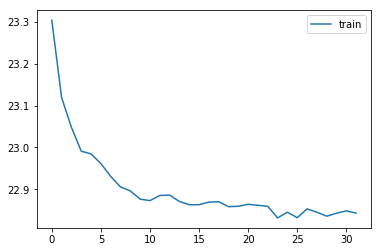

KeyError: "['mos_tot_num_mosquitos'] not in index"

In [32]:
# tensorboard --logdir pathlib.Path('c:/users/stephen.hage/documents')

from time import time
scaler = MinMaxScaler()
earlystopper = EarlyStopping(monitor='loss', min_delta=0, patience=8, verbose=0, 
                       mode='auto', baseline=None, restore_best_weights=True)
# testtrapout = testtrap.fillna(0).drop('mos_tot_num_mosquitos', axis = 1)
test_dat = dat.loc[dat.part_train == True, get_relevant_columns(dat, 'mos_tot_num_mosquitos')].fillna(0)
# y_scaler = scaler.fit(testtrap.mos_tot_num_mosquitos)
y = test_dat.mos_tot_num_mosquitos
test_dat = test_dat.drop('mos_tot_num_mosquitos', axis = 1)
X_scaler = scaler.fit(test_dat)

X = X_scaler.transform(test_dat)
X = X.reshape((X.shape[0], 1, X.shape[1]))
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adamax')
history = model.fit(X, y.values, epochs = 200, batch_size = 10, shuffle = False, verbose = 2, callbacks = [earlystopper])
plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
# preds = test_dat[['mos_tot_num_mosquitos',]]
# preds['preds'] = model.predict(X)
# preds.head(30)

In [47]:
# model.predict(X)
# pd.DataFrame({'actuals': y.reshape(-1,1), 'preds': model.predict(X)})

validate_lstm = dat.loc[dat.part_validate == True, get_relevant_columns(dat,'mos_tot_num_mosquitos')].fillna(0)
val_y = validate_lstm.mos_tot_num_mosquitos
validate_lstm = X_scaler.transform(validate_lstm.drop('mos_tot_num_mosquitos', axis = 1))

validate_lstm = validate_lstm.reshape((validate_lstm.shape[0], 1, validate_lstm.shape[1]))

testout = pd.DataFrame({'actuals': val_y, 'preds': model.predict(validate_lstm).reshape(-1,)})
testout.head(25)




,actuals,preds
8222,84,2.266059
8223,9,2.091587
8224,82,2.653544
8225,90,2.041140
8226,46,2.004983
8227,15,1.930991
8228,2,1.926036
8229,15,2.100249
8230,32,1.932138
8231,54,2.101494


In [5]:
from keras.utils import plot_model  
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)  


ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [12]:
preds = list()
for pred in model.predict(X):
    preds.append(pred[0])
pd.DataFrame({'actuals': y, 'preds': preds})

,actuals,preds
0,2,1.938948
1,9,1.694961
2,6,7.376787
3,2,5.414062
4,5,12.659562
5,27,24.091516
6,13,26.734890
7,35,33.831314
8,179,35.412457
9,26,38.884594


In [22]:


    
trap1 = get_trap_data(dat, 'T002', 'mos_tot_num_mosquitos')
print(trap1.shape)
trap1 = pd.concat([trap1, trap1.shift(-1)], axis = 1)
trap1.head()

(185, 92)


,t_yr,t_mo,t_day,t_qtr,t_wk,t_day_of_yr,t_day_of_wk,t_eval_day,t_eval_wk,part_train,...,wea_ohare_tavg2_ma60_lag14,wea_ohare_tavg2_ma60_lag21,wea_ohare_tavg2_ma60_lag28,wea_ohare_tavg2_ma60_lag35,wea_ohare_tavg2_ma60_lag42,wea_ohare_tavg2_ma60_lag49,wea_ohare_tavg2_ma60_lag56,wea_ohare_tavg2_ma60_lag63,wea_ohare_tavg2_ma60_lag90,wea_ohare_tavg2_ma60_lag120
t_date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,2007,5,29,2,22,149,2,514,74,True,...,53.175000,51.008333,48.725000,44.691667,42.100000,38.616667,35.550000,31.775000,22.058333,30.316667
2007-06-05,2007,6,5,2,23,156,2,521,75,True,...,61.141667,57.316667,54.375000,53.175000,51.008333,48.725000,44.691667,42.100000,28.266667,24.233333
2007-06-26,2007,6,26,2,26,177,2,542,78,True,...,62.733333,59.041667,55.441667,54.033333,52.316667,50.116667,46.333333,43.133333,29.825000,23.608333
2007-06-29,2007,6,29,2,26,180,5,545,78,True,...,64.275000,60.533333,56.800000,54.183333,53.041667,50.341667,48.083333,44.350000,31.775000,23.116667
2007-07-02,2007,7,2,3,27,183,1,548,79,True,...,66.975000,65.091667,61.658333,57.750000,54.766667,53.558333,51.616667,49.158333,36.575000,22.525000


In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
#     df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
series_to_supervised(trap1)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var108(t),var109(t),var110(t),var111(t),var112(t),var113(t),var114(t),var115(t),var116(t),var117(t)
19,2007-05-29,2007.0,5.0,29.0,2.0,22.0,149.0,2.0,Mon,514.0,...,53.175000,51.008333,48.725000,44.691667,42.100000,38.616667,35.550000,31.775000,22.058333,30.316667
59,2007-06-05,2007.0,6.0,5.0,2.0,23.0,156.0,2.0,Mon,521.0,...,61.141667,57.316667,54.375000,53.175000,51.008333,48.725000,44.691667,42.100000,28.266667,24.233333
104,2007-06-26,2007.0,6.0,26.0,2.0,26.0,177.0,2.0,Mon,542.0,...,62.733333,59.041667,55.441667,54.033333,52.316667,50.116667,46.333333,43.133333,29.825000,23.608333
140,2007-06-29,2007.0,6.0,29.0,2.0,26.0,180.0,5.0,Thu,545.0,...,64.275000,60.533333,56.800000,54.183333,53.041667,50.341667,48.083333,44.350000,31.775000,23.116667
189,2007-07-02,2007.0,7.0,2.0,3.0,27.0,183.0,1.0,Sun,548.0,...,66.975000,65.091667,61.658333,57.750000,54.766667,53.558333,51.616667,49.158333,36.575000,22.525000
265,2007-07-11,2007.0,7.0,11.0,3.0,28.0,192.0,3.0,Tue,557.0,...,68.133333,66.975000,65.091667,61.658333,57.750000,54.766667,53.558333,51.616667,39.766667,24.175000
353,2007-07-18,2007.0,7.0,18.0,3.0,29.0,199.0,3.0,Tue,564.0,...,70.358333,68.775000,67.433333,65.325000,62.733333,59.041667,55.441667,54.033333,43.400000,28.641667
405,2007-07-27,2007.0,7.0,27.0,3.0,30.0,208.0,5.0,Thu,573.0,...,71.275000,69.875000,68.133333,66.975000,65.091667,61.658333,57.750000,54.766667,45.775000,31.775000
550,2007-08-01,2007.0,8.0,1.0,3.0,31.0,213.0,3.0,Tue,578.0,...,71.550000,70.958333,69.566667,67.900000,66.425000,64.766667,61.141667,57.316667,49.158333,35.008333
654,2007-08-07,2007.0,8.0,7.0,3.0,32.0,219.0,2.0,Mon,584.0,...,72.525000,71.725000,71.275000,69.875000,68.133333,66.975000,65.091667,61.658333,52.008333,38.616667


In [ ]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

In [21]:

rf_params = {'n_estimators': [100, 500, 1000, ],
                'max_depth': [2, 3, 4],
                'min_samples_leaf': [1, 2, 3], 
             'max_features': ['auto', ]}
rf = RandomForestRegressor()
rf = GridSearchCV(estimator = rf, param_grid = rf_params, cv = 5)
rf.fit(train_x, train_y)
# ridge_params = {'alpha': [.0001, .001, .01, .1, .5, 1],
#                 'normalize': [True, False],
#                 'tol': [.0001, .001, .01], 'solver': ['auto', 'svd', 'lsqr', 'sag']}

# reg = Ridge()
# ridge = GridSearchCV(estimator = reg, param_grid = ridge_params, n_jobs = 1)
# ridge.fit(train_x, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 500, 1000], 'max_depth': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'max_features': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [20]:
train_x, train_y, valid_x, valid_y, test_x, test_y = make_x(dat, 'mos_tot_num_mosquitos')
rf = RandomForestRegressor()

rf.fit(train_x, train_y)

rf.predict(valid_x)

array([ 6.6       , 21.4       , 34.2       , ..., 44.03722222,
       44.03722222, 44.03722222])

In [62]:

    
# basic_nnet(train_x, train_y, test_x, test_y)

NameError: name 'reg' is not defined

In [23]:


le = LabelEncoder()
# dat.trap_trap_type = 
le.fit_transform(dat.trap_trap_type)

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [235]:
# train60619, test60619 = split_zip(dat, 'mos_tot_num_mosquitos', 60619)
# np.asarray(test60619).reshape(1)
# test60619.values.reshape(-1, 1)
# for col in dat.columns:
#     print(col)
# dat['latlong'] = tuple([dat.loc_lat, dat.loc_lng])
# dat.head()
# dat.loc_lat.shape
# dat['latlong'] = list(zip(dat.loc_lat, dat.loc_lng))
len(dat.loc_zipcode.unique())

47

## Notes:
<ol>
<li>Remove mosquito count vars</li>
<li>Output date, lat, long, mosq count by speciss</li>
<li>Output is csv in data/output</li>
    <ul>
        <li>Name convention is regr-modeltype-whatever.csv</li>
    </ul>
    </ol>

In [212]:
window = 10
lstm_scaler = MinMaxScaler(feature_range = (-1, 1))
scaled = lstm_scaler.fit_transform(test60619.values.reshape(-1,1))
lstm_dat = pd.DataFrame(scaled,)
series_y = lstm_dat.copy()
for i in range(window):
    lstm_dat = pd.concat([lstm_dat, series_y.shift(i+1)], axis = 1)
lstm_dat
model = Sequential()
model.add(LSTM(11, input_shape =(None, lstm_dat.shape[-1])))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
# lstm_dat.shape[-1]
# lstm_dat.values.reshape(lstm_dat.shape[0],1,1)
model.summary()
model.fit(lstm_dat.values.reshape(-1,1,1), 
          test60619.values, 
          epochs = 100,)
# lstm_dat.values.reshape(lstm_dat.values.shape[0], 1)
# lstm_dat.values.shape


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 11)                1012      
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 12        
Total params: 1,024
Trainable params: 1,024
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking input: expected lstm_49_input to have shape (None, 11) but got array with shape (1, 1)

In [117]:
preds_out = pd.DataFrame(test_y,)
preds_out['predicted_tot_num_mosquitos'] = model.predict(test_x)
preds_out.to_csv(fulldatpath / pathlib.Path('basic_neural_net_preictions.csv'), index = False)

In [109]:

estimator = KerasRegressor(build_fn = make_model, epochs = 100, batch_size = 5, verbose = 0)
kfold = KFold(n_splits=10, random_state = 1337)
ests = [('standardize', StandardScaler()), ('mlp', KerasRegressor(build_fn=make_model, epochs = 50, batch_size = 5, verbose = 0))]
pipeline = Pipeline(ests)
results = cross_val_score(pipeline, train_x, train_y, cv = kfold)
print("Standardized: %2f (%.2f) MSE" % (results.mean(), results.std()))


Standardized: -194337109775003157182886430375936.000000 (583008895365774233787579525758976.00) MSE
